In [1]:
from dmp import DMPs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DMP_discrete(DMPs):
    def __init__(self, **kwargs):
        super(DMP_discrete, self).__init__(pattern='discrete', **kwargs)
        
        self.bfs_center_term()
        
        self.h = np.ones(self.n_bfs)*self.n_bfs**1.5/self.c/self.cs.a_x
        
        self.check_offset()
        
    def bfs_center_term(self):
        """
        set the center of the Gaussian basis functions 
        to be spaced envely throughout the whole run time
        """
        
        c_des = np.linspace(0, self.cs.runTime, self.n_bfs)
        self.c = np.ones(len(c_des))
        for i in range(len(c_des)):
            self.c[i] = np.exp(-self.cs.a_x*c_des[i])
        
    def f_front_term(self, x, dmp_idx):
        """
        diminishing term for forcing function
        """
        return x*(self.goal[dmp_idx] - self.y_0[dmp_idx])
    
    def f_weight_term(self, f_target):
        """
        generate a set of wegihts over the basis functions s.t.
        the target forcing term trajectory is matched
        
        - f_target np.array: desired forcing term trajectory
        """
        x_track = np.zeros(self.cs.n_step)
        for i in range(self.cs.n_step):
            x_track[i] = self.cs.step()
        psi_track = self.gen_psi(x_track)

        # calculate BF weights using weighted linear regression
        self.w = np.zeros((self.n_dmps, self.n_bfs))
        for j in range(self.n_dmps):
            scale = self.goal[j] - self.y_0[j] # spatial scaling term
            for k in range(self.n_bfs):
                numer = np.sum(x_track*psi_track[:, k]*f_target[:, j])
                denom = np.sum(x_track**2*psi_track[:, k])
                self.w[j, k] = numer/(scale*denom)
        self.w = np.nan_to_num(self.w)

    def gen_psi(self, x):
        """Generates the activity of the basis functions for a given
        canonical system rollout.

        x float, array: the canonical system state or path
        """
        if isinstance(x, np.ndarray):
            x = x[:, None]

        return np.exp(-self.h * (x - self.c)**2)
    
    def gen_goal(self, y_des):
        """Generate the goal for path imitation.
        For rhythmic DMPs the goal is the average of the
        desired trajectory.

        y_des np.array: the desired trajectory to follow
        """

        return np.copy(y_des[:, -1])

[ 0.]
[ 1.]


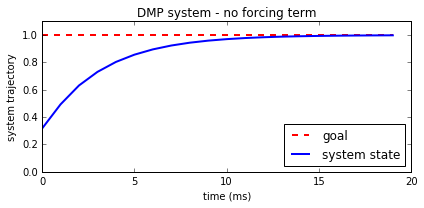

In [3]:
# define system parameters w/o feedback
runTime = 1.0
dt = 0.05
n_dmps = 1
n_bfs = 10

dmp = DMP_discrete(n_dmps=n_dmps, n_bfs=n_bfs, dt=dt, runTime=runTime)
y_traj = np.zeros((dmp.n_step, dmp.n_dmps))
dy_traj = np.zeros((dmp.n_step, dmp.n_dmps))
ddy_traj = np.zeros((dmp.n_step, dmp.n_dmps))
for i in range(dmp.n_dmps):
    for j in range(dmp.n_step):
        y_traj[j, i], dy_traj[j, i], ddy_traj[j, i] = dmp.step()
# y_traj, dy_traj, ddy_traj = dmp.rollout()

plt.figure(1, figsize=(6, 3))
plt.plot(np.ones(len(y_traj[:, 0]))*dmp.goal, 'r--', lw=2)
plt.plot(y_traj[:, 0], lw=2)
plt.title('DMP system - no forcing term')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.ylim([0, 1.1])
plt.legend(['goal', 'system state'], loc='lower right')
plt.tight_layout()
plt.show()

[ 0.]
[ 1.]


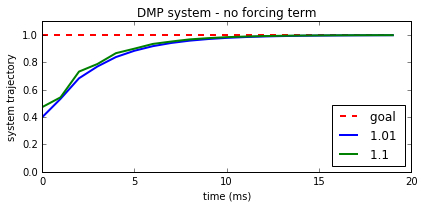

In [4]:
# define system parameters w/o feedback
runTime = 1.0
dt = 0.05
n_dmps = 1
n_bfs = 10
tau = [1.01, 1.1]


dmp = DMP_discrete(n_dmps=n_dmps, n_bfs=n_bfs, dt=dt, runTime=runTime)
y_traj = np.zeros((len(tau), dmp.n_step, dmp.n_dmps))
dy_traj = np.zeros((len(tau), dmp.n_step, dmp.n_dmps))
ddy_traj = np.zeros((len(tau), dmp.n_step, dmp.n_dmps))
for l in range(len(tau)):
    for i in range(dmp.n_dmps):
        for j in range(dmp.n_step):
            y_traj[l, j, i], dy_traj[l, j, i], ddy_traj[l, j, i] = dmp.step(tau=tau[l])
    if l == 0:
        plt.figure(1, figsize=(6, 3))
        plt.plot(np.ones(len(y_traj[l, :, 0]))*dmp.goal, 'r--', lw=2)
    plt.plot(y_traj[l, :, 0], lw=2)
    plt.title('DMP system - no forcing term')
    plt.xlabel('time (ms)')
    plt.ylabel('system trajectory')
    plt.ylim([0, 1.1])
    plt.xlim([0, 20])
    
    plt.tight_layout()
    dmp.reset()
leg = ['goal']
for idx, value in enumerate(tau):
    leg.append(value)
plt.legend(['%s ' % i for i in leg], loc='lower right')
plt.show()


[ 0.  0.]
[ 1.  1.]
[ 0.  0.]
[-0.97190307  0.5       ]
[ 0.  0.]
[ 1.  1.]
[ 0.  0.]
[-0.97190307  0.5       ]
[ 0.  0.]
[ 1.  1.]
[ 0.  0.]
[-0.97190307  0.5       ]
[ 0.  0.]
[ 1.  1.]
[ 0.  0.]
[-0.97190307  0.5       ]
[ 0.  0.]
[ 1.  1.]
[ 0.  0.]
[-0.97190307  0.5       ]


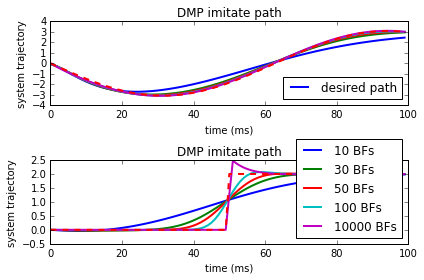

In [5]:
# define system parameters
runTime = 1.0
dt = 0.01
n_dmps = 2
bfs = [10, 30, 50, 100, 10000]
n_bfs = len(bfs)

path1 = np.sin(5*np.arange(0, runTime, dt))
path2 = np.zeros(path1.shape)
path2[int(len(path2)/2.):] = 0.5
# print(path1, path2)

for idx, value in enumerate(bfs):
    dmp = DMP_discrete(n_dmps=n_dmps, runTime=runTime, dt=dt, n_bfs=value)
    
    dmp.imitate_path(y_des=np.array([path1, path2]))
    dmp.goal[0] = 3
    dmp.goal[1] = 2
    
    y_traj = np.zeros((dmp.n_step, dmp.n_dmps))
    dy_traj = np.zeros((dmp.n_step, dmp.n_dmps))
    ddy_traj = np.zeros((dmp.n_step, dmp.n_dmps))
#     for i in range(dmp.n_dmps):
#         for j in range(dmp.n_step):
#             y_traj[j, i], dy_traj[j, i], ddy_traj[j, i] = dmp.step()
    for i in range(dmp.n_step):
        y_traj[i], dy_traj[i], ddy_traj[i] = dmp.step()
    
    
    plt.figure(2)
    plt.subplot(211)
    plt.plot(y_traj[:, 0], lw=2)
    plt.subplot(212)
    plt.plot(y_traj[:, 1], lw=2)
    
    
plt.subplot(211)
plt.plot(path1 / path1[-1] * dmp.goal[0], 'r--', lw=2)
plt.title('DMP imitate path')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.legend(['desired path'], loc='lower right')
plt.subplot(212)
plt.plot(path2 / path2[-1] * dmp.goal[1], 'r--', lw=2)
plt.title('DMP imitate path')
plt.xlabel('time (ms)')
plt.ylabel('system trajectory')
plt.legend(['%i BFs' % i for i in bfs], loc='lower right')

plt.tight_layout()
plt.show()